In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from geopy.geocoders import Nominatim
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import missingno as msno
import math

# 1. Data preparation

## 1.1. Data cleaning

In [2]:
df_sessions = pd.read_pickle('data/ga_sessions.pkl')
df_sessions.head(5)

session_id              client_id  \
0  9055434745589932991.1637753792.1637753792  2108382700.1637753791   
1   905544597018549464.1636867290.1636867290   210838531.1636867288   
2  9055446045651783499.1640648526.1640648526  2108385331.1640648523   
3  9055447046360770272.1622255328.1622255328  2108385564.1622255328   
4  9055447046360770272.1622255345.1622255345  2108385564.1622255328   

   visit_date visit_time  visit_number            utm_source utm_medium  \
0  2021-11-24   14:36:32             1  ZpYIoDJMcFzVoPFsHGJL     banner   
1  2021-11-14   08:21:30             1  MvfHsxITijuriZxsqZqt        cpm   
2  2021-12-28   02:42:06             1  ZpYIoDJMcFzVoPFsHGJL     banner   
3  2021-05-29   05:00:00             1  kjsLglQLzykiRbcDiGcD        cpc   
4  2021-05-29   05:00:00             2  kjsLglQLzykiRbcDiGcD        cpc   

           utm_campaign         utm_adcontent           utm_keyword  \
0  LEoPHuyFvzoNfnzGgfcd  vCIpmpaGBnIQhyYNkXqp  puhZPIYqKXeFPaUviSjo   
1  FTjNLDyTrXaWYgZymFkV  xhoenQgDQsgfEPYNPwKO  IGUCNvHlhfHpROGclCit   
2  LEoPHuyFvzoNfnzGgfcd  vCIpmpaGBnIQhyYNkXqp  puhZPIYqKXeFPaUviSjo   
3                   NaN  NOBKLgtuvqYWkXQHeYWM                   NaN   
4                   NaN                   NaN                   NaN   

  device_category device_os device_brand device_model  \
0          mobile   Android       Huawei          NaN   
1          mobile   Android      Samsung          NaN   
2          mobile   Android       Huawei          NaN   
3          mobile      None       Xiaomi          NaN   
4          mobile      None       Xiaomi          NaN   

  device_screen_resolution    device_browser geo_country     geo_city  
0                  360x720            Chrome      Russia     Zlatoust  
1                  385x854  Samsung Internet      Russia       Moscow  
2                  360x720            Chrome      Russia  Krasnoyarsk  
3                  393x786            Chrome      Russia       Moscow  
4                  393x786            Chrome      Russia       Moscow

In [3]:
df_clean = df_sessions.copy()

In [4]:
space_mask = ((df_clean['device_brand'] == '') | (df_clean['device_brand'].str.isspace()))
df_clean.loc[space_mask, 'device_brand'] = None
not_set_brand_mask = (df_clean['device_brand'] == '(not set)')
df_clean.loc[not_set_brand_mask, 'device_brand'] = None
not_set_os_mask = (df_clean['device_os'] == '(not set)')
df_clean.loc[not_set_os_mask, 'device_os'] = None
not_set_browser_mask = (df_clean['device_browser'] == '(not set)')
df_clean.loc[not_set_os_mask, 'device_browser'] = None

<Axes: >

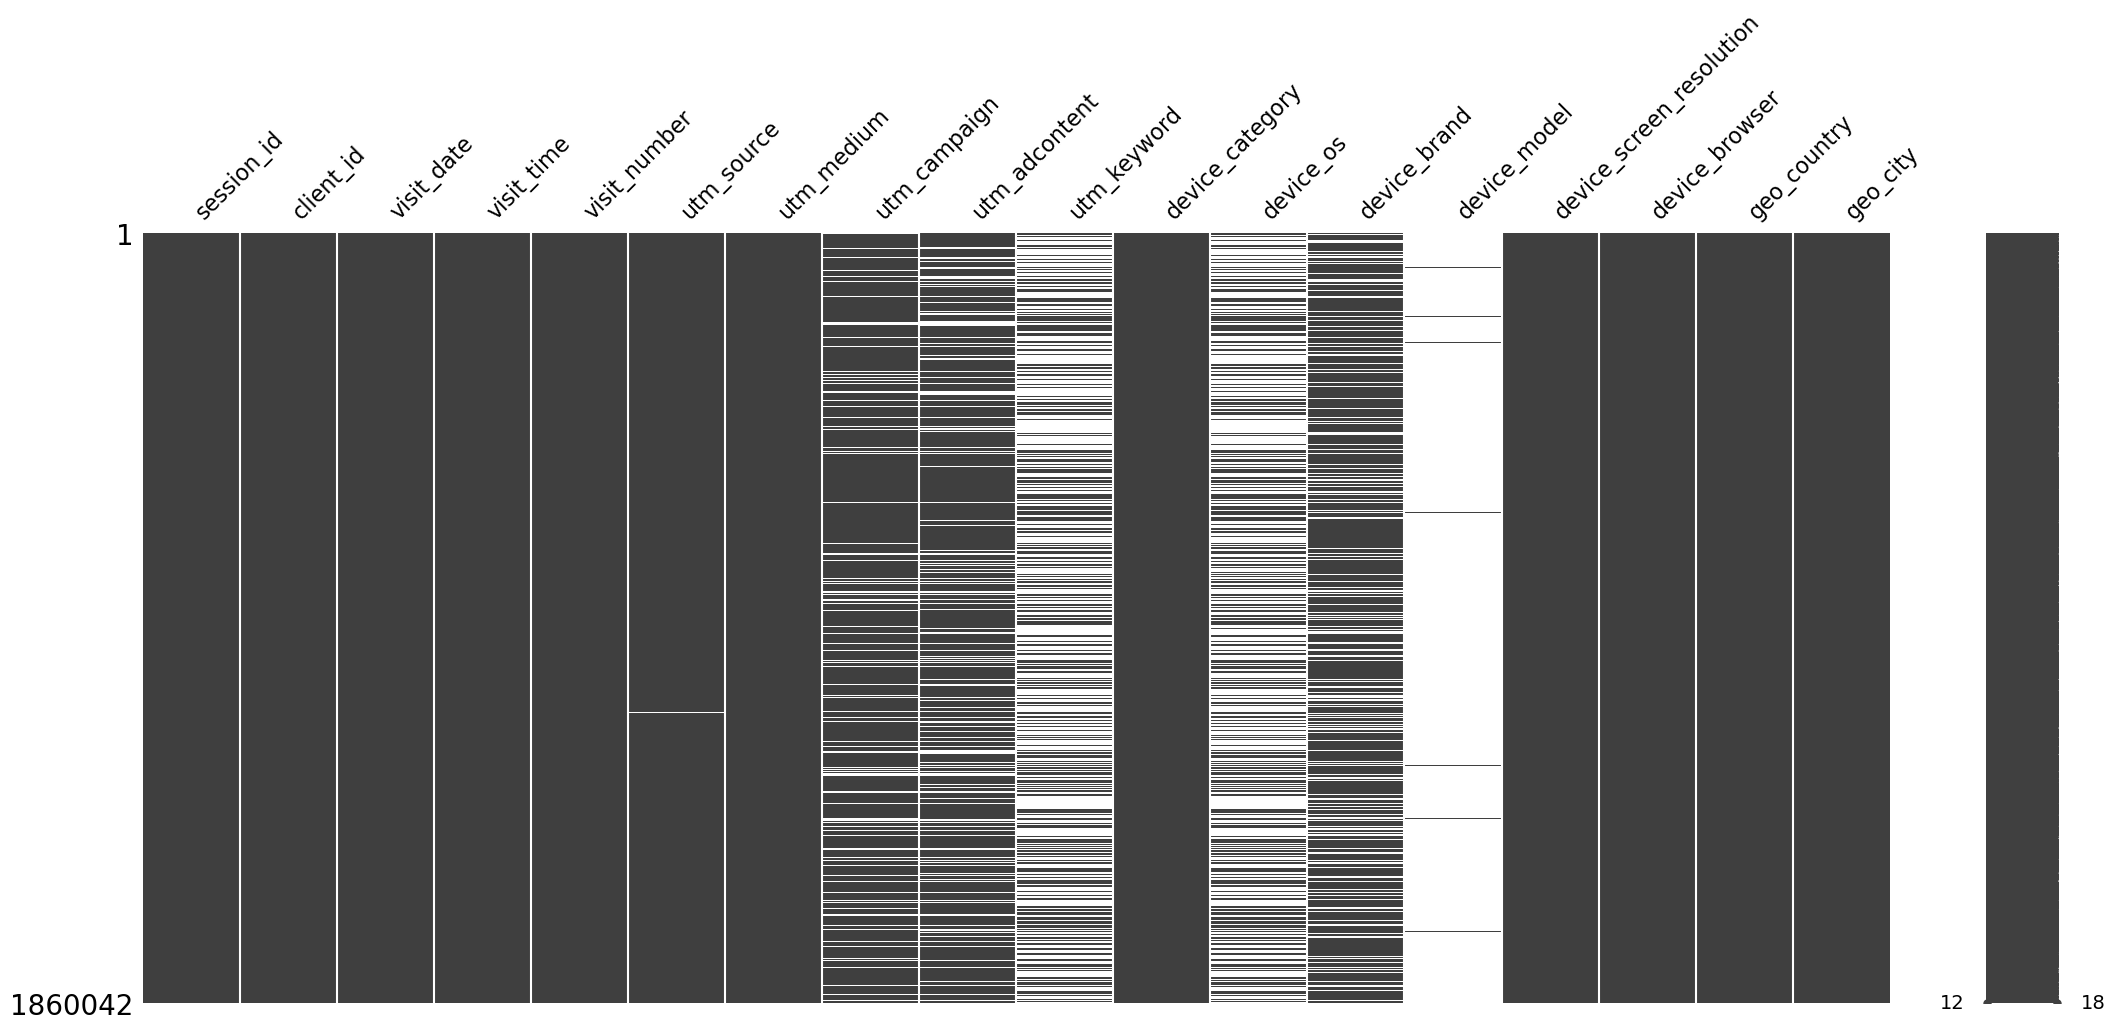

In [5]:
msno.matrix(df_clean)

In [6]:
def get_missing_values_percantage(data):
  output = (round((data.isna().sum() / len(data)) * 100, 2)).sort_values(ascending=False)
  return output

In [7]:
missing_values_sessions = get_missing_values_percantage(df_clean)
for index, value in missing_values_sessions.items():
  if value > 0:
    print(f'Имеются пропущенные значения {index}: {value} %')

Имеются пропущенные значения device_model: 99.12 %
Имеются пропущенные значения utm_keyword: 58.17 %
Имеются пропущенные значения device_os: 57.55 %
Имеются пропущенные значения device_brand: 20.68 %
Имеются пропущенные значения utm_adcontent: 18.04 %
Имеются пропущенные значения utm_campaign: 11.81 %
Имеются пропущенные значения device_browser: 0.02 %
Имеются пропущенные значения utm_source: 0.01 %


По возможности заполним пустые значения в device_brand и device_os, на основнии других параметров. Начнем с устройств Apple. Бразуер Safari работает только на их устройствах, поэтому там где нет device_os мы може заполнить значение на iOS или Macintosh.

In [8]:
df_apple_sessions_mobile = ((df_clean['device_brand'] == 'Apple') & (df_clean['device_os'].isna()) & (df_clean['device_category'] == 'mobile'))
df_apple_sessions_tablet = ((df_clean['device_brand'] == 'Apple') & (df_clean['device_os'].isna()) & (df_clean['device_category'] == 'tablet'))
df_apple_sessions_desktop = ((df_clean['device_brand'] == 'Apple') & (df_clean['device_os'].isna()) & (df_clean['device_category'] == 'desktop'))
df_clean.loc[df_apple_sessions_mobile, 'device_os'] = 'iOS'
df_clean.loc[df_apple_sessions_tablet, 'device_os'] = 'iOS'
df_clean.loc[df_apple_sessions_desktop, 'device_os'] = 'Macintosh'

In [9]:
df_safari_sessions_mobile_os_na = ((df_clean['device_browser'].str.contains('Safari')) & (df_clean['device_os'].isna()) & (df_clean['device_category'] == 'mobile'))
df_safari_sessions_tablet_os_na = ((df_clean['device_browser'].str.contains('Safari')) & (df_clean['device_os'].isna()) & (df_clean['device_category'] == 'tablet'))
df_safari_sessions_desktop_os_na = ((df_clean['device_browser'].str.contains('Safari')) & (df_clean['device_os'].isna()) & (df_clean['device_category'] == 'desktop'))
df_clean.loc[df_safari_sessions_mobile_os_na, 'device_os'] = 'iOS'
df_clean.loc[df_safari_sessions_tablet_os_na, 'device_os'] = 'iOS'
df_clean.loc[df_safari_sessions_desktop_os_na, 'device_os'] = 'Macintosh'

In [10]:
df_safari_sessions_brand_na = (df_clean['device_browser'].str.contains('Safari') & (df_clean['device_brand'].isna()))
apple_mac_mask = ((df_clean['device_os'] == 'Macintosh') & (df_clean['device_brand'].isna()))
df_clean.loc[df_safari_sessions_brand_na, 'device_brand'] = 'Apple'
df_clean.loc[apple_mac_mask, 'device_brand'] = 'Apple'

In [11]:
missing_values_sessions = get_missing_values_percantage(df_clean)
for index, value in missing_values_sessions.items():
  if value > 0:
    print(f'Имеются пропущенные значения {index}: {value} %')

Имеются пропущенные значения device_model: 99.12 %
Имеются пропущенные значения utm_keyword: 58.17 %
Имеются пропущенные значения device_os: 37.58 %
Имеются пропущенные значения utm_adcontent: 18.04 %
Имеются пропущенные значения device_brand: 17.87 %
Имеются пропущенные значения utm_campaign: 11.81 %
Имеются пропущенные значения device_browser: 0.02 %
Имеются пропущенные значения utm_source: 0.01 %


Т.к. даже после заполнения device_model, utm_keyword, device_osсодержит более 20% пропусков считем эти солбцы не информативными и удаляем их.

In [12]:
df_clean = df_clean.drop(['device_model', 'utm_keyword', 'device_os'], axis=1)

В столбце device_brand заполним пропуски значением Unknown

In [13]:
df_clean.loc[df_clean['device_brand'].isna(), 'device_brand'] = 'Unknown'

<Axes: >

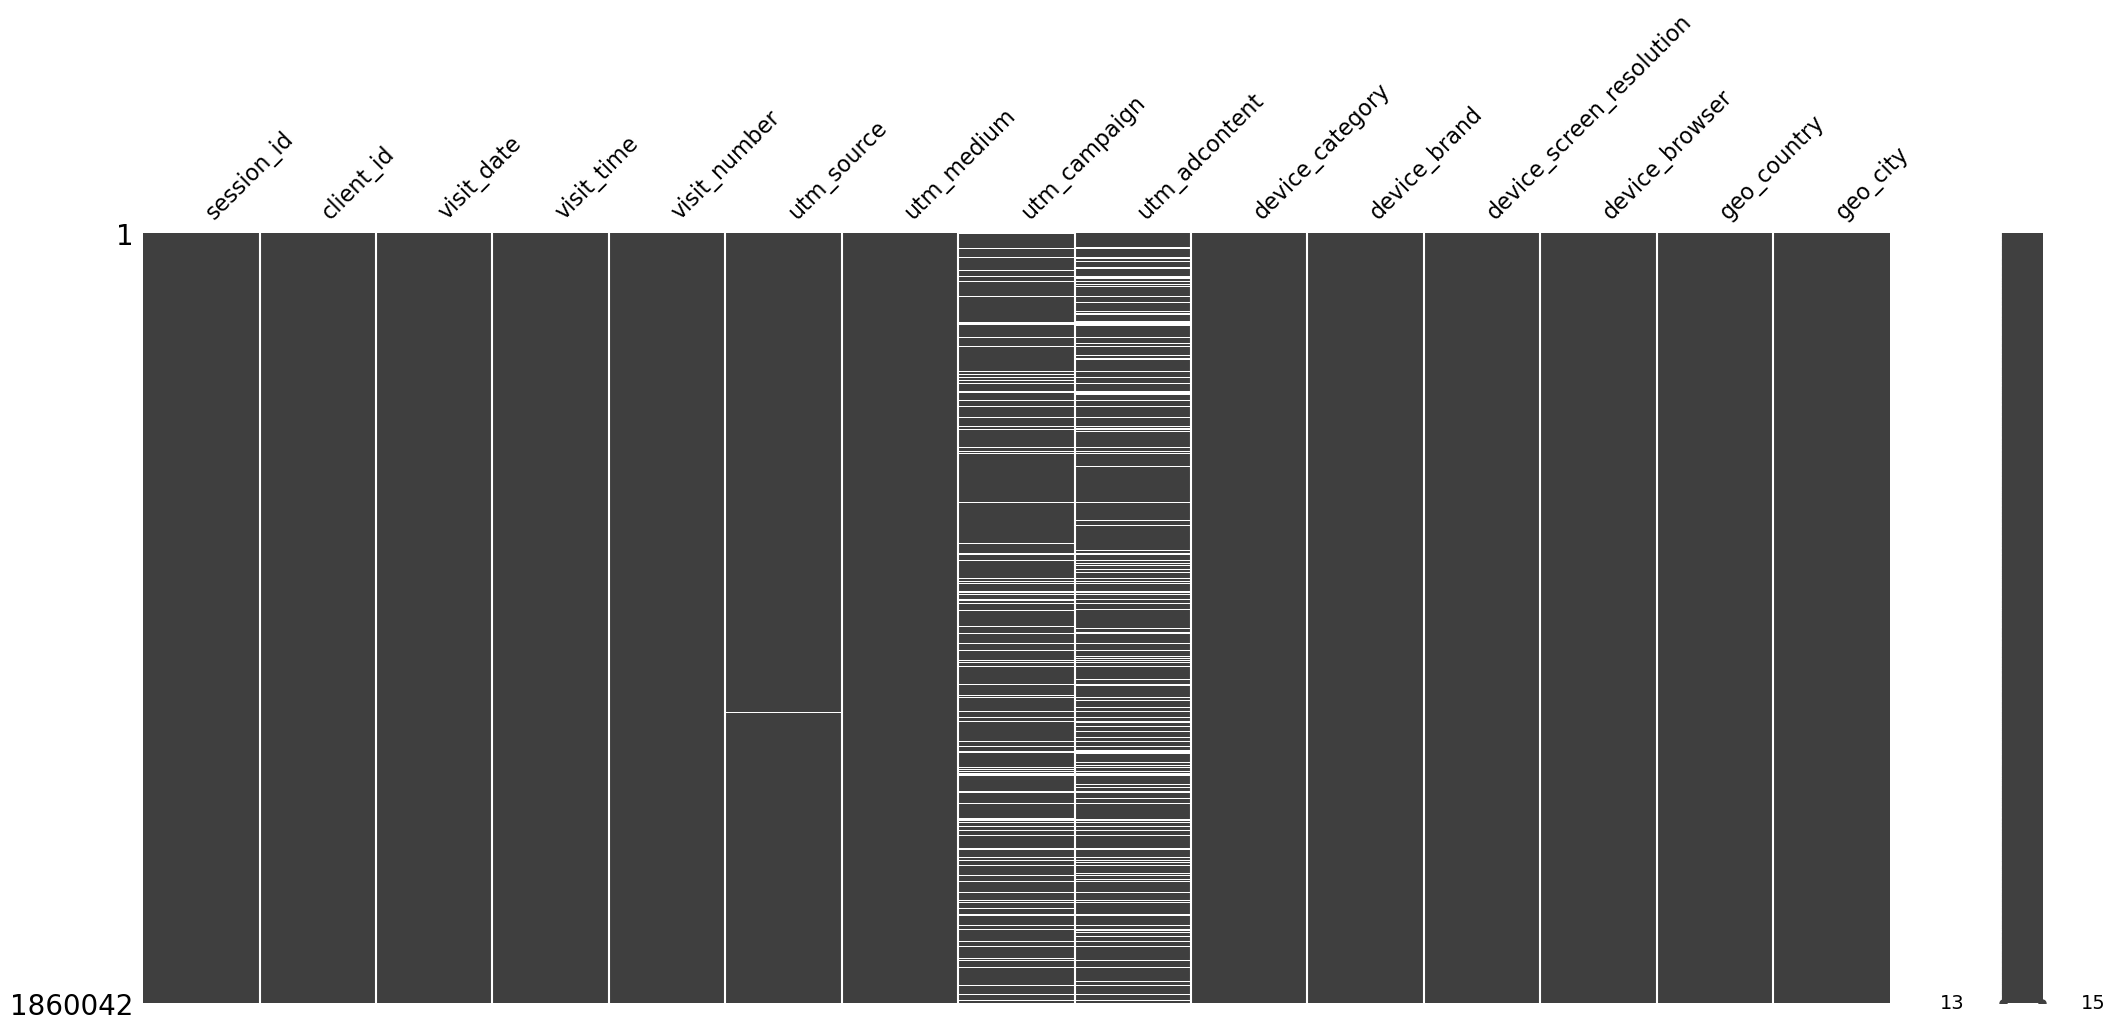

In [14]:
msno.matrix(df_clean)

In [15]:
missing_values_sessions = get_missing_values_percantage(df_clean)
for index, value in missing_values_sessions.items():
  if value > 0:
    print(f'Имеются пропущенные значения {index}: {value} %')

Имеются пропущенные значения utm_adcontent: 18.04 %
Имеются пропущенные значения utm_campaign: 11.81 %
Имеются пропущенные значения device_browser: 0.02 %
Имеются пропущенные значения utm_source: 0.01 %


## 1.2. Удаление выбросов

In [16]:
def get_boundaries(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (round(q25 - 1.5 * iqr), round(q75 + 1.5 * iqr))
    return boundaries

In [17]:
df_clean['visit_number'].value_counts()

1      1376349
2       235656
3        81068
4        41666
5        24271
        ...   
419          1
420          1
421          1
422          1
564          1
Name: visit_number, Length: 537, dtype: int64

In [18]:
boundaries = get_boundaries(df_clean['visit_number'])
boundaries

(0, 4)

In [19]:
is_outlier = (df_clean['visit_number'] < boundaries[0]) | (df_clean['visit_number'] > boundaries[1])
is_outlier.sum()

125303

In [20]:
df_clean.loc[is_outlier, 'visit_number'] = boundaries[1]
boundaries = None

In [21]:
df_clean['visit_number'].value_counts()

1    1376349
2     235656
4     166969
3      81068
Name: visit_number, dtype: int64

## 1.3 Загрузка и фильтрация df_hits

Отфильтруем значения в df_hits, оставив только целевые

In [4]:
df_hits = pd.read_pickle('data/ga_hits.pkl')

In [5]:
df_hits.head(5)

session_id    hit_date  hit_time  \
0  5639623078712724064.1640254056.1640254056  2021-12-23  597864.0   
1  7750352294969115059.1640271109.1640271109  2021-12-23  597331.0   
2   885342191847998240.1640235807.1640235807  2021-12-23  796252.0   
3   142526202120934167.1640211014.1640211014  2021-12-23  934292.0   
4  3450086108837475701.1640265078.1640265078  2021-12-23  768741.0   

   hit_number hit_type hit_referer  \
0          30    event         NaN   
1          41    event         NaN   
2          49    event         NaN   
3          46    event         NaN   
4          79    event         NaN   

                                       hit_page_path event_category  \
0  sberauto.com/cars?utm_source_initial=google&ut...           quiz   
1  sberauto.com/cars/fiat?city=1&city=18&rental_c...           quiz   
2  sberauto.com/cars/all/volkswagen/polo/e994838f...           quiz   
3  sberauto.com/cars?utm_source_initial=yandex&ut...           quiz   
4  sberauto.com/cars/all/mercedes-benz/cla-klasse...           quiz   

  event_action event_label event_value  
0    quiz_show         NaN        None  
1    quiz_show         NaN        None  
2    quiz_show         NaN        None  
3    quiz_show         NaN        None  
4    quiz_show         NaN        None

In [6]:
df_hits_filtered = df_hits[((df_hits['event_action'] == 'sub_car_claim_click') | (df_hits['event_action'] == 'sub_car_claim_submit_click') | (df_hits['event_action'] == 'sub_open_dialog_click') | (df_hits['event_action'] == 'sub_custom_question_submit_click') | (df_hits['event_action'] == 'sub_call_number_click') | (df_hits['event_action'] == 'sub_callback_submit_click') | (df_hits['event_action'] == 'sub_submit_success') | (df_hits['event_action'] == 'sub_car_request_submit_click'))]

In [7]:
df_hits_filtered.shape

(104908, 11)

Объеденим датафреймы

In [8]:
df_hits = df_hits_filtered.groupby('session_id').count()
merged_df = pd.merge(df_clean, df_hits[['event_action']], on='session_id', how='left')
merged_df.loc[merged_df['event_action'].isna(), 'event_action'] = 0

In [9]:
merged_df.loc[merged_df['event_action'] > 0, 'event_action'] = 1

Удалим неинформативные колонки

In [28]:
merged_df = merged_df.drop(['session_id', 'client_id'], axis=1)

## 1.4 Data type conversion

In [29]:
merged_df['visit_time'] = merged_df['visit_time'].astype('str')
merged_df['event_action'] = merged_df['event_action'].astype('int64')

Очистим датафрейм от данных с пропусками в device_browser, utm_source, utm_campaign, utm_adcontent

In [30]:
merged_df = merged_df[merged_df['utm_source'].notna()]
merged_df = merged_df[merged_df['device_browser'].notna()]
merged_df = merged_df[merged_df['utm_campaign'].notna()]
merged_df = merged_df[merged_df['utm_adcontent'].notna()]

In [31]:
missing_values_sessions = get_missing_values_percantage(df_clean)
for index, value in missing_values_sessions.items():
  if value > 0:
    print(f'Имеются пропущенные значения {index}: {value} %')

Имеются пропущенные значения utm_adcontent: 18.04 %
Имеются пропущенные значения utm_campaign: 11.81 %
Имеются пропущенные значения device_browser: 0.02 %
Имеются пропущенные значения utm_source: 0.01 %


Сохраним объединенный датафрейм

## 1.5 Сохранение объединенного датафрейма

In [32]:
merged_df.to_csv('data/merged_df_new.csv') 

In [16]:
test = merged_df.copy()
test.loc[:, ['geo_city_lower']] = test['geo_city'].apply(labmda x: )
output = test['geo_city'].unique()
len(output)

2343

# 2. Feature engeneering

In [18]:
merged_df = pd.read_csv('data/merged_df_new.csv', index_col=0)

## 2.1 Generation new features

In [6]:
def encode_city_location(city_name, geolocator):
    location = geolocator.geocode(city_name)
    if not location:
        print(city_name)
        location = geolocator.geocode('(not set)')
    return [location.latitude, location.longitude]

In [7]:
def get_city_names_list(df_column):
    output = df_column.unique()
    return output

In [8]:
def calculate_city_coords(cities_list, geolocator):
    output = dict()
    for city_name in cities_list:
        output[city_name] = encode_city_location(city_name, geolocator)
    return output

In [36]:
geolocator = Nominatim(user_agent="my_application")
city_names_list = get_city_names_list(merged_df['geo_city'])
city_coords_list = calculate_city_coords(city_names_list, geolocator)
for item in city_coords_list:
    merged_df.loc[merged_df['geo_city'] == item, ['city_lat', 'city_long']] = city_coords_list[item][0], city_coords_list[item][1],
merged_df.head(5)

Tuymazy
Petrovo-Dalneye
Yablonovsky
Oktyabrs'ke
Zagorjanskas
Belebey
Armyans'k
Khartsyz'k
Novoye Devyatkino
Krasnoturyinsk
Zhigulevsk
Kalininets
Chusovskoye Urban Settlement
Yenakijeve
Shakhtars'k
Debal'tseve
Velykodolyns'ke
Pervomais'k
Troedobelikovskiy
Chornomors'ke
Kolomyya
Roven'ky
Alchevs'k
Hresivs'kyi
Dzhankoi
Berdyans'k
Arsenyev
Dobropillya
Dorokhovskoja
Emel'yanovo
Bilohirs'k
Novomikhailovskii
Ilovais'k
Voronezjskaja
Wolno-Nadeschdinskoje
Zavolzhye
Veliky Ustyug
Chystiakove
Krasnohvardiis'ke
Sovjets'kyi
Novoazovs'k
Lorenskog Municipality
Artemovskiy
Dokuchajevs'k
Mohyliv-Podil's'kyi
Starobil's'k
Yuzhnoukrains'k
Krasnoperekops'k
Stolberg (Rhineland)
Timiskaming, Unorganized, East Part
Bilhorod-Dnistrovs'kyi
Fredrikstad Municipality
Novoukrainskoye
Pereval's'k
Lyubotyn
Sandnes Municipality
Korsun'-Shevchenkivs'kyi
Kostyantynivka
Synel'nykove
Novhorod-Sivers'kyi
Stavanger Municipality
Nyzhnya Krynka
Novohrad-Volyns'kyi
Mikkeli Province
Ullensaker Municipality
Kam'yanets'-Podil's'k

visit_date visit_time  visit_number            utm_source utm_medium  \
0  2021-11-24   14:36:32             1  ZpYIoDJMcFzVoPFsHGJL     banner   
1  2021-11-14   08:21:30             1  MvfHsxITijuriZxsqZqt        cpm   
2  2021-12-28   02:42:06             1  ZpYIoDJMcFzVoPFsHGJL     banner   
5  2021-05-31   12:00:00             1  kjsLglQLzykiRbcDiGcD    organic   
6  2021-12-30   08:56:28             1  TxKUcPpthBDPieTGmVhx        cpc   

           utm_campaign         utm_adcontent device_category device_brand  \
0  LEoPHuyFvzoNfnzGgfcd  vCIpmpaGBnIQhyYNkXqp          mobile       Huawei   
1  FTjNLDyTrXaWYgZymFkV  xhoenQgDQsgfEPYNPwKO          mobile      Samsung   
2  LEoPHuyFvzoNfnzGgfcd  vCIpmpaGBnIQhyYNkXqp          mobile       Huawei   
5  LTuZkdKfxRGVceoWkVyg  JNHcPlZPxEMWDnRiyoBf          mobile        Apple   
6  FTjNLDyTrXaWYgZymFkV  LcGIUNPUAmXtQJaDfFBR          tablet       Lenovo   

  device_screen_resolution    device_browser geo_country          geo_city  \
0                  360x720            Chrome      Russia          Zlatoust   
1                  385x854  Samsung Internet      Russia            Moscow   
2                  360x720            Chrome      Russia       Krasnoyarsk   
5                  375x812            Safari      Russia  Saint Petersburg   
6                 602x1029         YaBrowser      Russia  Saint Petersburg   

   event_action   city_lat  city_long  
0             0  55.167421  59.679263  
1             0  55.750446  37.617494  
2             0  56.009097  92.872515  
5             0  27.770380 -82.669509  
6             0  27.770380 -82.669509

In [37]:
merged_df['short_browser'] = merged_df['device_browser'].apply(lambda x: x.split(' ')[0])

In [38]:
merged_df = merged_df.drop([
    'device_browser',
], axis=1)

In [39]:
def calculate_hour(income_string):
    splitted_string = income_string.split(':')
    hour = int(splitted_string[0])
    minutes = int(splitted_string[1])
    if minutes > 30:
        if hour == 23:
            hour = 0
        else:
            hour += 1
    return hour

In [40]:
merged_df['visit_date'] = pd.to_datetime(merged_df['visit_date'])
merged_df['visit_dayofweek'] = merged_df['visit_date'].dt.dayofweek
merged_df['visit_day'] = merged_df['visit_date'].dt.day
merged_df['visit_month'] = merged_df['visit_date'].dt.month
merged_df['visit_hour'] = merged_df['visit_time'].apply(lambda x: calculate_hour(x))

In [41]:
merged_df = merged_df.drop([
    'visit_date',
    'visit_time',
], axis=1)

In [42]:
def fill_pixel_sum(income_string):
    if income_string == '(not set)':
        return 10
    splitted_string = income_string.split('x')
    pixel_sum = int(splitted_string[0]) * int(splitted_string[1])
    return pixel_sum

In [43]:
def encode_pixels(income_row):
    income_string = income_row['device_screen_resolution']
    if income_string == '(not set)':
        return [10, 10]
    splitted_string = income_string.split('x')
    pixel_sum = int(splitted_string[0]) * int(splitted_string[1])
    return [int(splitted_string[0]), int(splitted_string[1])]

pixel_numbers = merged_df.apply(lambda x: encode_pixels(x), axis=1, result_type='expand')
pixel_numbers.columns = ['pixel_width', 'pixel_height']
merged_df = pd.concat([merged_df.reset_index(drop=True), pixel_numbers.reset_index(drop=True)], axis=1)

In [44]:
merged_df = merged_df.drop([
    'device_screen_resolution',
], axis=1)

In [45]:
merged_df['pixel_width'] = merged_df['pixel_width'].apply(lambda x: x/10)
merged_df['pixel_width'] = merged_df['pixel_width'].round(0)
merged_df['pixel_height'] = merged_df['pixel_height'].apply(lambda x: x/10)
merged_df['pixel_height'] = merged_df['pixel_height'].round(0)

In [46]:
merged_df.to_csv('data/merged_df_city_encoded.csv') 

## 2.2 Feature standartization

In [5]:
merged_df = pd.read_csv('data/merged_df_city_encoded.csv', index_col=0)
merged_df.head(5)

visit_number            utm_source utm_medium          utm_campaign  \
0             1  ZpYIoDJMcFzVoPFsHGJL     banner  LEoPHuyFvzoNfnzGgfcd   
1             1  MvfHsxITijuriZxsqZqt        cpm  FTjNLDyTrXaWYgZymFkV   
2             1  ZpYIoDJMcFzVoPFsHGJL     banner  LEoPHuyFvzoNfnzGgfcd   
3             1  kjsLglQLzykiRbcDiGcD    organic  LTuZkdKfxRGVceoWkVyg   
4             1  TxKUcPpthBDPieTGmVhx        cpc  FTjNLDyTrXaWYgZymFkV   

          utm_adcontent device_category device_brand geo_country  \
0  vCIpmpaGBnIQhyYNkXqp          mobile       Huawei      Russia   
1  xhoenQgDQsgfEPYNPwKO          mobile      Samsung      Russia   
2  vCIpmpaGBnIQhyYNkXqp          mobile       Huawei      Russia   
3  JNHcPlZPxEMWDnRiyoBf          mobile        Apple      Russia   
4  LcGIUNPUAmXtQJaDfFBR          tablet       Lenovo      Russia   

           geo_city  event_action   city_lat  city_long short_browser  \
0          Zlatoust             0  55.167421  59.679263        Chrome   
1            Moscow             0  55.750446  37.617494       Samsung   
2       Krasnoyarsk             0  56.009097  92.872515        Chrome   
3  Saint Petersburg             0  27.770380 -82.669509        Safari   
4  Saint Petersburg             0  27.770380 -82.669509     YaBrowser   

   visit_dayofweek  visit_day  visit_month  visit_hour  pixel_width  \
0                2         24           11          15         36.0   
1                6         14           11           8         38.0   
2                1         28           12           3         36.0   
3                0         31            5          12         38.0   
4                3         30           12           9         60.0   

   pixel_height  
0          72.0  
1          85.0  
2          72.0  
3          81.0  
4         103.0

In [3]:
quantity_varaiables = ['city_lat', 'city_long']
data = merged_df.loc[:, quantity_varaiables]
mm_scaler = MinMaxScaler()
mm_scaler.fit(data)
mm_scaled = mm_scaler.transform(data)
merged_df[['lat_mm', 'long_mm']] = mm_scaled

In [4]:
quantity_varaiables = ['visit_number', 'visit_dayofweek', 'visit_day', 'visit_month', 'visit_hour', 'pixel_width', 'pixel_height']
data = merged_df.loc[:, quantity_varaiables]
std_scaler = StandardScaler()
std_scaler.fit(data)
std_scaled = std_scaler.transform(data)
renamed_columns = []
for varaiable in quantity_varaiables:
    renamed_columns.append(varaiable + '_std')
merged_df[renamed_columns] = std_scaled
data = None
std_scaled = None

In [5]:
merged_df = merged_df.drop([
    'city_lat',
    'city_long',
    'pixel_width',
    'pixel_height'
], axis=1)

## 2.3 Downsampling dataset

In [6]:
df_majority = merged_df[merged_df['event_action']==0]
df_minority = merged_df[merged_df['event_action']==1]
df_minority_len = df_minority.shape[0]
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=df_minority_len,  # to match minority class
                                 random_state=852) # reproducible results
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
df_downsampled['event_action'].value_counts()

0    40999
1    40999
Name: event_action, dtype: int64

In [8]:
merged_df = df_downsampled.copy()
df_downsampled = None

## 2.4 Feature Transformation

In [9]:
target_categories = [
    'utm_source',
    'utm_medium',
#     'utm_medium_type',
    'utm_campaign',
    'utm_adcontent',
#     'utm_keyword',
#     'visit_number',
    'device_category',
    'device_brand',
    'short_browser',
#     'device_os',
#     'screen_category',
#     'device_browser',
#     'pixel_sum_std',
#     'device_screen_resolution',
#     'geo_country',
#     'geo_city',
#     'visit_dayofweek',
#     'visit_day',
#     'visit_month',
#     'visit_hour'
#     'visit_day_time',
#     'week_part'
]
for category in target_categories:
  print('В категории ' + category + ' уникальных значений: ' + str(merged_df[category].nunique()))

В категории utm_source уникальных значений: 133
В категории utm_medium уникальных значений: 36
В категории utm_campaign уникальных значений: 189
В категории utm_adcontent уникальных значений: 152
В категории device_category уникальных значений: 3
В категории device_brand уникальных значений: 77
В категории short_browser уникальных значений: 16


In [10]:
data = merged_df.loc[:, target_categories]

In [11]:
ohe = OneHotEncoder(sparse_output=False)
ohe.fit(data)
ohe_data = ohe.transform(data)
ohe_data.shape

(81999, 606)

In [12]:
ohe_data_df = pd.DataFrame(ohe_data,columns=list(ohe.get_feature_names_out()))

In [13]:
merged_df = merged_df.drop([
    'utm_source',
    'utm_medium',
    'utm_adcontent',
    'utm_campaign',
    'device_category',
    'device_brand',
    'short_browser',
#     'device_os',
#     'utm_keyword',
#     'device_model',
#     'screen_category',
    'visit_number',
#     'device_browser',
#     'device_screen_resolution',
    'geo_country',
    'geo_city',
#     'visit_day_time',
#     'week_part',
    'visit_dayofweek',
    'visit_day',
    'visit_month',
    'visit_hour',
], axis=1)

In [14]:
merged_df = pd.concat([merged_df.reset_index(drop=True), ohe_data_df.reset_index(drop=True)], axis=1)

In [15]:
ohe_data = None
ohe_data_df = None

# 3 Modeling

## 3.1 C-Support Vector Classification 

In [16]:
x = merged_df.drop(['event_action'], axis=1)
y = merged_df['event_action']
merged_df = None

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [17]:
clf = SVC(gamma='auto')
clf.fit(x_train, y_train)

SVC(gamma='auto')

In [18]:
predicted_test = clf.predict(x_test)
print(accuracy_score(y_test, predicted_test))
confusion_matrix(y_test, predicted_test)

0.619349593495935


array([[5999, 6308],
       [3056, 9237]])

In [36]:
roc_auc_score(y_test, predicted_test)

0.6194247032309502

## 3.2 Random Forecs Classifier

In [19]:
rf_clf = RandomForestClassifier(random_state=42, bootstrap=True, n_estimators=200, min_samples_split=15)
rf_clf.fit(x_train, y_train)

RandomForestClassifier(min_samples_split=15, n_estimators=200, random_state=42)

In [20]:
predicted_test_rf = rf_clf.predict(x_test)
print(accuracy_score(y_test, predicted_test_rf))
predicted_train_rf = rf_clf.predict(x_train)
print(accuracy_score(y_train, predicted_train_rf))
confusion_matrix(y_test, predicted_test_rf)

0.6478048780487805
0.8450669872297427


array([[7484, 4823],
       [3841, 8452]])

In [21]:
predicted_proba = rf_clf.predict_proba(x_test)
predicted_proba

array([[0.45988153, 0.54011847],
       [0.38244557, 0.61755443],
       [0.97406005, 0.02593995],
       ...,
       [0.6089919 , 0.3910081 ],
       [0.79763295, 0.20236705],
       [0.32590608, 0.67409392]])

In [22]:
threshold = 0.515
predicted_proba1 = rf_clf.predict_proba(x_test)
predicted1 = (predicted_proba1 [:,1] >= threshold).astype('int')

In [23]:
roc_auc_score(y_test, predicted_test_rf)

0.6478274819455788

In [24]:
print(accuracy_score(y_test, predicted1))
confusion_matrix(y_test, predicted1)

0.6478048780487805


array([[7888, 4419],
       [4245, 8048]])

In [25]:
# 0.6402849497682014 без фильтрации unknown в utm_compaign и utm_adcontent
roc_auc_score(y_test, predicted1)

0.6478087893623549

## 3.3 MPL Classifier

In [26]:
mlp = MLPClassifier(random_state=42, activation='tanh', max_iter=3200, hidden_layer_sizes=5, learning_rate='adaptive', solver='lbfgs', learning_rate_init = 0.01, shuffle = False, alpha= 0.001)
mlp.fit(x_train, y_train)

/home/roman/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(activation='tanh', alpha=0.001, hidden_layer_sizes=5,
              learning_rate='adaptive', learning_rate_init=0.01, max_iter=3200,
              random_state=42, shuffle=False, solver='lbfgs')

In [27]:
pred_mlp = mlp.predict(x_test)
accuracy_score(y_test, pred_mlp)

0.6358943089430894

In [28]:
confusion_matrix(y_test, pred_mlp)

array([[7315, 4992],
       [3965, 8328]])

In [29]:
roc_auc_score(y_test, pred_mlp)

0.635917950029609

In [30]:
threshold_mlp = 0.61
predicted_proba_mlp = mlp.predict_proba(x_test)
predicted_mlp = (predicted_proba_mlp [:,1] >= threshold_mlp).astype('int')

In [31]:
accuracy_mlp = accuracy_score(y_test, predicted_mlp)

In [32]:
accuracy_mlp

0.6084959349593496

In [33]:
confusion_matrix(y_test, predicted_mlp)

array([[9987, 2320],
       [7311, 4982]])

In [34]:
roc_auc_score(y_test, predicted_mlp)

0.6083803444420443

In [35]:
for item in range(15,60):
    threshold_mlp = item/100
    predicted_proba_mlp = mlp.predict_proba(x_test)
    predicted_mlp = (predicted_proba_mlp [:,1] >= threshold_mlp).astype('int')
    print(item)
    print(roc_auc_score(y_test, predicted_mlp))

15
0.5507330225786113
16
0.5533321509238905
17
0.5560534850064165
18
0.5584494306565014
19
0.5609672118936704
20
0.5618996961668656
21
0.5638887212013176
22
0.567259120204223
23
0.5701418529773996
24
0.5732279997896226
25
0.5759887581694041
26
0.5783026626798233
27
0.5811449069740263
28
0.5844738458537805
29
0.5876399054422327
30
0.5903186226823486
31
0.5926718126837123
32
0.59506553743282
33
0.5974178020587765
34
0.6007457230255828
35
0.6035044455794688
36
0.6054903706063068
37
0.6086954380730814
38
0.6121428811884537
39
0.615589352659649
40
0.6187515256713911
41
0.6211404847371522
42
0.6245866323269547
43
0.6275843066404324
44
0.6294439080094619
45
0.6307740128754487
46
0.6323067914801559
47
0.6348163368762014
48
0.6350485333953211
49
0.6353617994099291
50
0.635917950029609
51
0.6367993502754192
52
0.6361352480046741
53
0.6349841272669854
54
0.6331419725292925
55
0.6304860228291038
56
0.6277912040569039
57
0.6240788524017697
58
0.6205293337691675
59
0.6171835530570038
